In this notebook, we will train an auto encoder to perform anomaly detection on a [credit card fraud](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set which can be found on Kaggle.

In [ ]:
!wget http://mg.bluecourses.com/wp-content/uploads/2020/04/creditcardfraud.zip -O creditcardfraud.zip

--2020-07-21 13:00:28--  http://mg.bluecourses.com/wp-content/uploads/2020/04/creditcardfraud.zip
Resolving mg.bluecourses.com (mg.bluecourses.com)... 46.30.215.75
Connecting to mg.bluecourses.com (mg.bluecourses.com)|46.30.215.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155672 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M  5.54MB/s    in 20s     

2020-07-21 13:00:48 (3.31 MB/s) - ‘creditcardfraud.zip’ saved [69155672/69155672]



In [ ]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.preprocessing import Normalizer, minmax_scale
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import itertools

Let's read in the data set and show it. Most of the variables here have been anonymized, but we do have `Time`, `Amount`, and `Class`, indicating whether a transaction was fraudulent or not.

In [ ]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.Time.describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

The `Time` column describes the time of the transaction, so we can use out-of-time testing here.

In [ ]:
df_train = data.loc[data.Time <= 139320].drop(columns='Time')
df_test  = data.loc[data.Time >  139320].drop(columns='Time')
y_train  = df_train.Class
y_test   = df_test.Class
df_train.drop(columns=['Class'], inplace=True)
df_test.drop(columns=['Class'],  inplace=True)

We also normalize the data, mainly due to the `Amount` feature.

In [ ]:
normalizer = Normalizer()
normalizer.fit(df_train)
X_train = normalizer.transform(df_train)
X_test  = normalizer.transform(df_test)

X_train.shape, y_train.shape

((213605, 29), (213605,))

We now construct our auto encoder.

In [ ]:
model = Sequential()

model.add(Dense(16, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='tanh'))
model.add(Dropout(0.25))

model.add(Dense(X_train.shape[1], activation='tanh'))

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                4

And as always, we train it.

Important is to note that we don't use `y_train` here: the auto encoder has no knowledge about the target and is unsupervised! (Also, new instances obviously will not contain the `Class` attribute, as this is exactly what we want to predict.)

In [ ]:
batch_size = 512
epochs     = 20

hist = model.fit(X_train, X_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, X_test),
          verbose=0)

We do need to take care of overfitting though, so let's make sure that has not occurred:

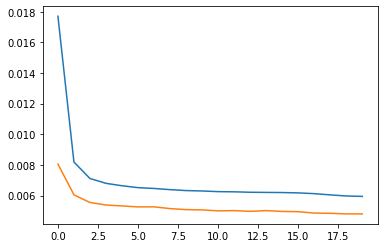

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

Now how do we use the predictions? One way would be to use the "reconstruction" error, meaning: how well is the network able to reconstruct each sample?

In [ ]:
pred_train, pred_test = model.predict(X_train), model.predict(X_test)
mse_train, mse_test   = np.sum((X_train - pred_train)**2, axis=1), np.sum((X_test - pred_test)**2, axis=1)

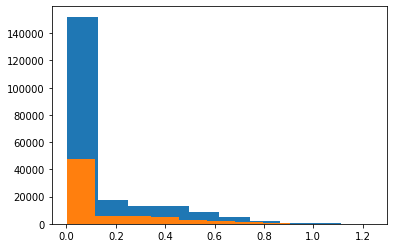

In [ ]:
plt.hist(mse_train)
plt.hist(mse_test)
plt.show()

There are some outliers present here, evidenced by the higher MSE. So let's see how good we would score based on this reconstruction error. We can simply rescale this to `[0, 1]` and then show an ROC curve.

Reconstruction error AUC = 0.7209607142386948


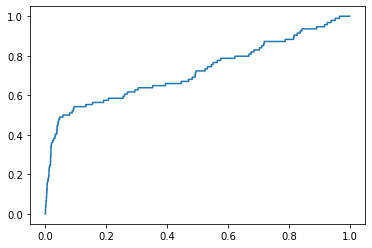

In [ ]:
fpr, tpr, _ = roc_curve(y_test, minmax_scale(mse_test))
print('Reconstruction error AUC =', auc(fpr, tpr))
plt.plot(fpr, tpr)

That's not too bad for a network that hasn't even seen the target!

Another method is to use the "embedding" in the bottleneck layer as features for another model:

In [ ]:
get_embedding = K.function(inputs=[model.input], outputs=[model.get_layer('dense_1').output])

In [ ]:
X_train_emb = get_embedding(X_train)[0]
X_test_emb  = get_embedding(X_test)[0]

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_emb, y_train)
rf_preds = rf.predict_proba(X_test_emb)

Embedding with RF AUC = 0.8638028429036324


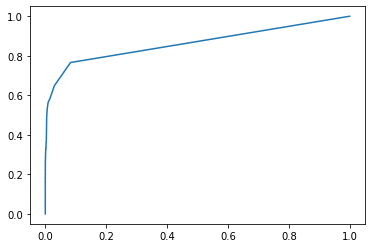

In [ ]:
fpr, tpr, _ = roc_curve(y_test, rf_preds[:, 1])
print('Embedding with RF AUC =', auc(fpr, tpr))
plt.plot(fpr, tpr)

That works even better! Let us try a couple more approaches. How would a non-neural network based anomaly detection technique such as isolation forest do?

In [ ]:
ifor = IsolationForest(n_estimators=100)
ifor.fit(X_train)
ifor_preds = ifor.score_samples(X_test)

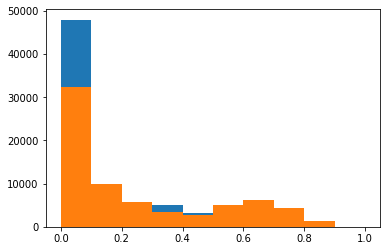

In [ ]:
plt.hist(minmax_scale(mse_test))
plt.hist(1 - minmax_scale(ifor_preds))
plt.show()

Isolation Forest AUC = 0.6648378881868635


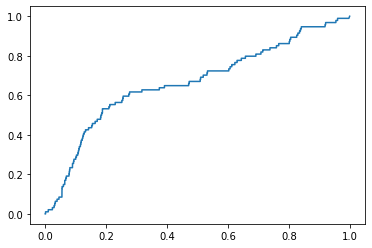

In [ ]:
fpr, tpr, _ = roc_curve(y_test, 1 - minmax_scale(ifor_preds))
print('Isolation Forest AUC =', auc(fpr, tpr))
plt.plot(fpr, tpr)

So far, it seems our auto-encoder does better.

But how about we forget about anomaly detection for a moment -- how does a random forest do when simply training it supervised on the original features?

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
rf_preds = rf.predict_proba(X_test)

Original features RF AUC = 0.9157710656490158


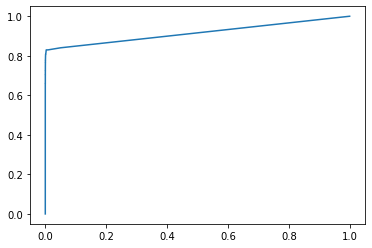

In [ ]:
fpr, tpr, _ = roc_curve(y_test, rf_preds[:, 1])
print('Original features RF AUC =', auc(fpr, tpr))
plt.plot(fpr, tpr)

This is expected... using a supervised model if possible is always the preferred option. (Similarly, we could have trained a neural network directly as well, obviously, which is something you can try out on your own -- and compare it with the random forest.)

One final interesting aspect to try is whether the random forest model would do even better if we add in all the anomaly scores we have calculated above as features... Let's go all out and compare all possible combinations.

In [ ]:
anomaly_scores = {
  'reconstruction': (np.expand_dims(mse_train, axis=-1), np.expand_dims(mse_test, axis=-1)),
  'embedding': (X_train_emb, X_test_emb),
  'isolationforest': (np.expand_dims(ifor.score_samples(X_train), axis=-1), np.expand_dims(ifor.score_samples(X_test), axis=-1)),
}

In [ ]:
results = {}

print('Original shapes are:', X_train.shape, X_test.shape)

# Train a model using all possible combinations of original features + anomaly score features
for r in range(len(anomaly_scores) + 1):
  for possibility in itertools.combinations(list(anomaly_scores.keys()), r=r):
    print('\nTraining with additional features:', possibility)
    X_train_expanded = X_train.copy()
    X_test_expanded  = X_test.copy()
    for key in possibility:
      X_train_expanded = np.hstack([X_train_expanded, anomaly_scores[key][0]])
      X_test_expanded  = np.hstack([X_test_expanded, anomaly_scores[key][1]])
    print('Shapes are now:', X_train_expanded.shape, X_test_expanded.shape)

    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train_expanded, y_train)
    rf_preds = rf.predict_proba(X_test_expanded)

    fpr, tpr, _ = roc_curve(y_test, rf_preds[:, 1])
    results[', '.join(possibility)] = (fpr, tpr)

Original shapes are: (213605, 29) (71202, 29)

Training with additional features: ()
Shapes are now: (213605, 29) (71202, 29)

Training with additional features: ('reconstruction',)
Shapes are now: (213605, 30) (71202, 30)

Training with additional features: ('embedding',)
Shapes are now: (213605, 37) (71202, 37)

Training with additional features: ('isolationforest',)
Shapes are now: (213605, 30) (71202, 30)

Training with additional features: ('reconstruction', 'embedding')
Shapes are now: (213605, 38) (71202, 38)

Training with additional features: ('reconstruction', 'isolationforest')
Shapes are now: (213605, 31) (71202, 31)

Training with additional features: ('embedding', 'isolationforest')
Shapes are now: (213605, 38) (71202, 38)

Training with additional features: ('reconstruction', 'embedding', 'isolationforest')
Shapes are now: (213605, 39) (71202, 39)


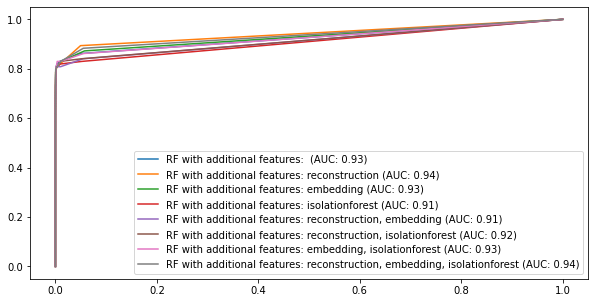

In [ ]:
plt.subplots(figsize=(10,5))
for key, (fpr, tpr) in results.items():
  plt.plot(fpr, tpr, label='RF with additional features: {} (AUC: {})'.format(key, np.round(auc(fpr, tpr), 2)))
plt.legend()
plt.show()

As you can see, for some additional features, our random forest indeed is able to get a slight improvement. Especially the reconstruction error seems to provide the best improvement here.